# Geometry computations: Example 6

In [2]:
from simba.mixins.geometry_mixin import GeometryMixin
from simba.mixins.config_reader import ConfigReader
from simba.utils.read_write import read_df, read_frm_of_video
from simba.utils.data import savgol_smoother
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib 
dpi = matplotlib.rcParams['figure.dpi']

In [3]:
FRAME_IDX = -1
BODY_PART = 'Nose'
VIDEO_NAME = 'SI_DAY3_308_CD1_PRESENT'
CONFIG_PATH = r'/Users/simon/Desktop/envs/simba/troubleshooting/mouse_open_field/project_folder/project_config.ini'

In [4]:
config = ConfigReader(config_path=CONFIG_PATH, read_video_info=False)
config.read_roi_data()
frm = read_frm_of_video(os.path.join(config.video_dir, VIDEO_NAME +'.mp4'), frame_index=FRAME_IDX)
shapes, colors = GeometryMixin.simba_roi_to_geometries(rectangles_df=config.rectangles_df, circles_df=config.circles_df, polygons_df=config.polygon_df, color=True)
video_roi_shapes = list(shapes[VIDEO_NAME].values())

In [5]:
#A HELPER FUNCTION TO HELP US VIEW THE GEOMETRIES CREATED IN THE BELOW CALLS WITHIN A JUPYTHER NOTEBOOK
def view_image(img):
    height, width, depth = img.shape
    figsize = width / float(dpi), height / float(dpi)
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

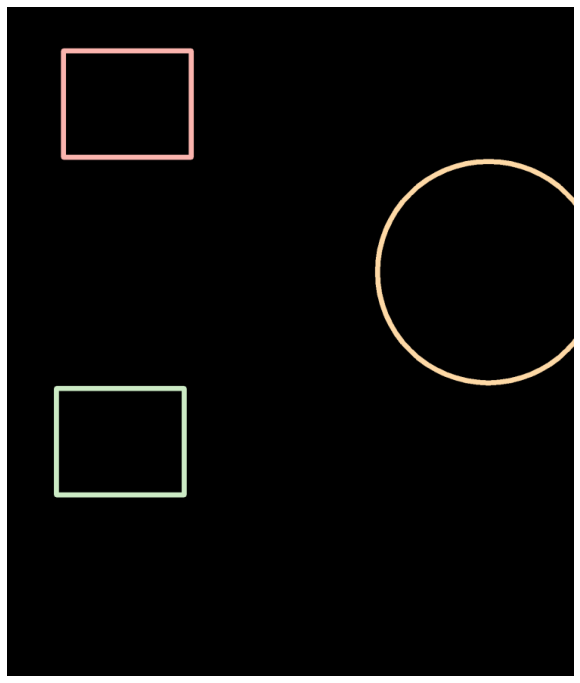

In [6]:
frm = read_frm_of_video(os.path.join(config.video_dir, VIDEO_NAME +'.mp4'), frame_index=FRAME_IDX)
roi_shapes = GeometryMixin.view_shapes(shapes=video_roi_shapes, size=750, thickness=12, bg_clr= (0, 0, 0), color_palette='Pastel1')
view_image(roi_shapes)

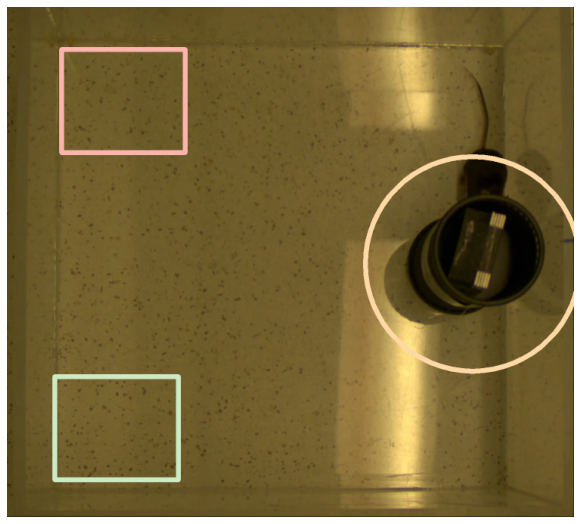

In [7]:
frm = cv2.cvtColor(read_frm_of_video(os.path.join(config.video_dir, VIDEO_NAME +'.mp4'), frame_index=FRAME_IDX), cv2.COLOR_RGB2BGR) 
roi_shapes = GeometryMixin.view_shapes(shapes=video_roi_shapes, size=750, thickness=12, bg_img=frm, color_palette='Pastel1')
view_image(roi_shapes)

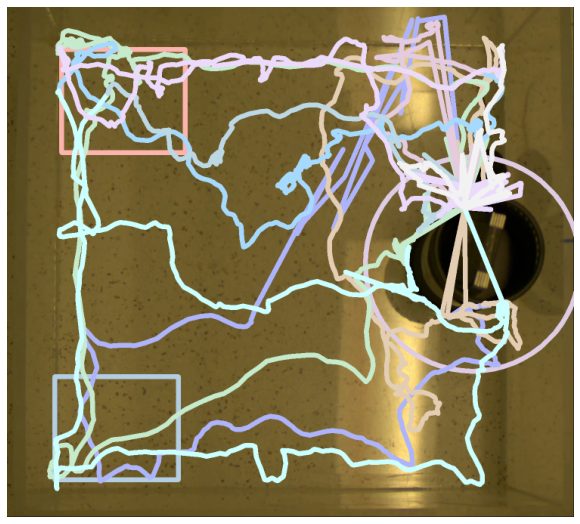

In [8]:
data_path = os.path.join(config.outlier_corrected_dir, VIDEO_NAME + f'.{config.file_type}')
df = read_df(data_path, file_type=config.file_type)
animal_data = df[['Nose_x', 'Nose_y']].values
animal_path = GeometryMixin.to_linestring(data=animal_data)
nose_path = GeometryMixin.view_shapes(shapes=video_roi_shapes + [animal_path], size=750, bg_img=frm, thickness=12, color_palette='Pastel1')
view_image(nose_path)

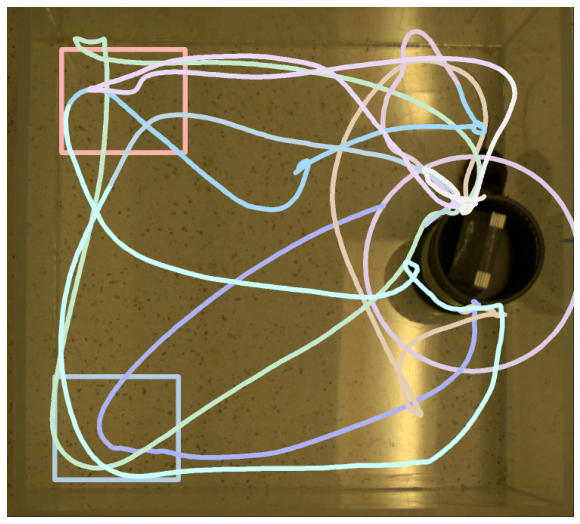

In [9]:
frm = cv2.cvtColor(read_frm_of_video(os.path.join(config.video_dir, VIDEO_NAME +'.mp4'), frame_index=FRAME_IDX), cv2.COLOR_RGB2BGR) 
animal_data = savgol_smoother(data=animal_data, fps=15, time_window=10000)
animal_path = GeometryMixin.to_linestring(data=animal_data)
animal_path_img = GeometryMixin.view_shapes(shapes=video_roi_shapes + [animal_path], size=750, bg_img=frm, thickness=12, color_palette='Pastel1')
view_image(animal_path_img)

In [10]:
# CALUCLATE LENGTH IN METER OF THE PATH
GeometryMixin.length(shape=animal_path, pixels_per_mm=1.5, unit='m')

12.895238446918457

In [11]:
#GET FRAMEWISE DISTANCES IN MILLIMETER TO THE TOP LEFT RECTANGLE
dist = GeometryMixin.locate_line_point(path=animal_path, px_per_mm=1.5, fps=15, geometry=shapes[VIDEO_NAME]['Top_left'])
dist['raw_distances']

array([241.6898558 , 236.53645033, 231.39810449, ..., 355.00869074,
       355.36371508, 355.63664313])

In [12]:
#GET FRAMEWISE DISTANCES IN MILLIMETER TO THE BOTTOM LEFT RECTANGLE
dist = GeometryMixin.locate_line_point(path=animal_path, px_per_mm=1.5, fps=15, geometry=shapes[VIDEO_NAME]['Bottom_left'])
dist['raw_distances']

array([313.83786515, 308.08441929, 302.19776243, ..., 416.43656028,
       417.00383123, 417.52029752])

In [13]:
#GET FRAME TIME STAMPS WHEN ANIMAL IS 10CM OR LESS FROM THE CAGE ROI
cage_dist = GeometryMixin.locate_line_point(path=animal_path, px_per_mm=1.5, fps=15, geometry=shapes[VIDEO_NAME]['Cage'])
np.argwhere(dist['raw_distances']  < 100).flatten() / 15

array([  2.13333333,   2.2       ,   2.26666667,   2.33333333,
         2.4       ,   2.46666667,   2.53333333,   2.6       ,
         2.66666667,   2.73333333,   2.8       ,   2.86666667,
         2.93333333,   3.        ,   3.06666667,   3.13333333,
         3.2       ,   3.26666667,   3.33333333,   3.4       ,
         3.46666667,   3.53333333,   3.6       ,   3.66666667,
         3.73333333,   3.8       ,   3.86666667,   3.93333333,
         4.        ,   4.06666667,   4.13333333,   4.2       ,
         4.26666667,   4.33333333,   4.4       ,   4.46666667,
         4.53333333,   4.6       ,   4.66666667,   4.73333333,
         4.8       ,   4.86666667,   4.93333333,   5.        ,
         5.06666667,   5.13333333,   5.2       ,   5.26666667,
         5.33333333,   5.4       ,   5.46666667,   5.53333333,
         5.6       ,   5.66666667,   5.73333333,   5.8       ,
         5.86666667,   5.93333333,   6.        ,   6.06666667,
         6.13333333,   6.2       ,   6.26666667,   6.33

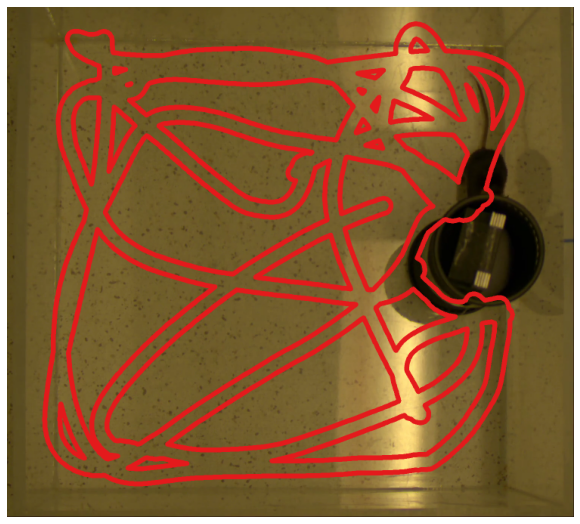

In [14]:
#BUFFER THE NOSE PATH WITH 3CM 
frm = cv2.cvtColor(read_frm_of_video(os.path.join(config.video_dir, VIDEO_NAME +'.mp4'), frame_index=FRAME_IDX), cv2.COLOR_RGB2BGR) 
buffered_path = GeometryMixin.buffer_shape(shape=animal_path, size_mm=30, pixels_per_mm=1.5)
buffered_path_img = GeometryMixin.view_shapes(shapes=[buffered_path], size=750, bg_img=frm, thickness=12, color_palette='Set1')
view_image(buffered_path_img)

In [15]:
#CHECK IF THE BUFFERED PATH INTERSECTS THE TOP LEFT ROI
buffered_path.intersects(shapes[VIDEO_NAME]['Top_left'])

True

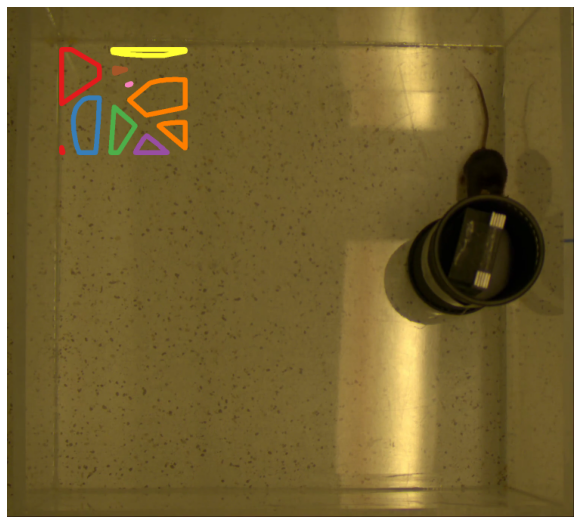

In [16]:
#GET THE PARTS OF THE TOP LEFT ROI WHICH IS NOT CROSSED BY THE BUFFERED PATH
frm = cv2.cvtColor(read_frm_of_video(os.path.join(config.video_dir, VIDEO_NAME +'.mp4'), frame_index=FRAME_IDX), cv2.COLOR_RGB2BGR) 
not_crossed = GeometryMixin.difference(shapes=[shapes[VIDEO_NAME]['Top_left'], buffered_path])
not_crossed_img = GeometryMixin.view_shapes(shapes=[not_crossed], size=750, bg_img=frm, thickness=12, color_palette='Set1')
view_image(not_crossed_img)

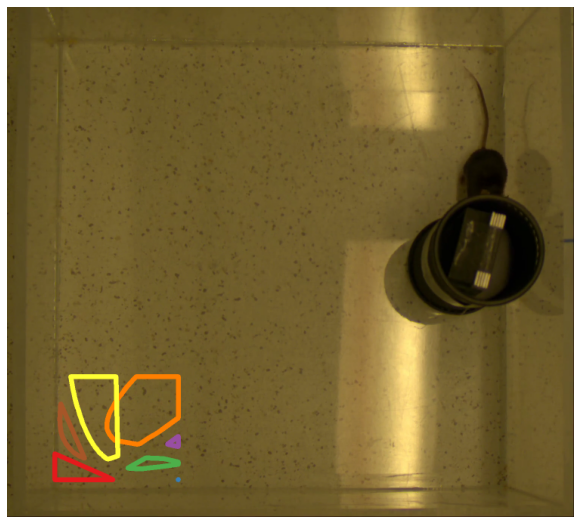

In [17]:
#GET THE PARTS OF THE BOTTOM LEFT ROI WHICH IS NOT CROSSED BY THE BUFFERED PATH
frm = cv2.cvtColor(read_frm_of_video(os.path.join(config.video_dir, VIDEO_NAME +'.mp4'), frame_index=FRAME_IDX), cv2.COLOR_RGB2BGR) 
not_crossed = GeometryMixin.difference(shapes=[shapes[VIDEO_NAME]['Bottom_left'], buffered_path])
not_crossed_img = GeometryMixin.view_shapes(shapes=[not_crossed], size=750, bg_img=frm, thickness=12, color_palette='Set1')
view_image(not_crossed_img)

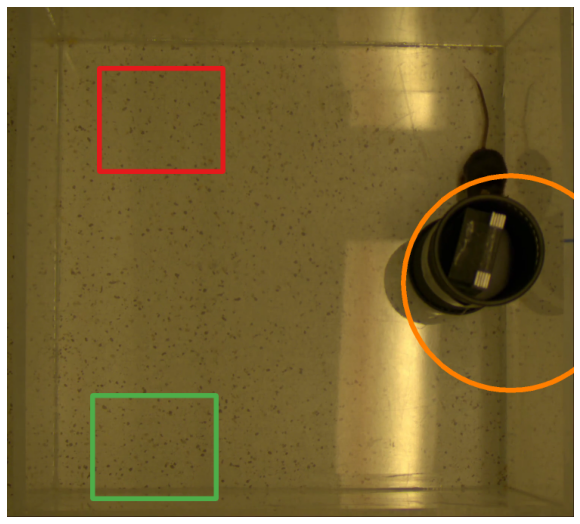

In [20]:
#SHIFT ALL GEOMETRIES 100PX TO THE LEFT AND 50PX TOWARDS THE BOTTOM
frm = cv2.cvtColor(read_frm_of_video(os.path.join(config.video_dir, VIDEO_NAME +'.mp4'), frame_index=FRAME_IDX), cv2.COLOR_RGB2BGR) 

shifted_geos = GeometryMixin.adjust_geometry_locations(geometries=video_roi_shapes, shift=(100, 50))
shifted_geos_img = GeometryMixin.view_shapes(shapes=shifted_geos, size=750, bg_img=frm, thickness=12, color_palette='Set1')
view_image(shifted_geos_img)

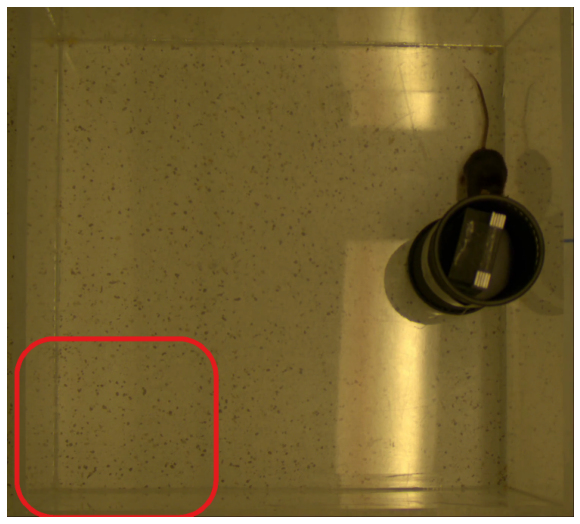

In [22]:
# MAKE THE BOTTOM LEFT ROI AREA LARGER WITH 15CM AND SMOOTH EDGES

frm = cv2.cvtColor(read_frm_of_video(os.path.join(config.video_dir, VIDEO_NAME +'.mp4'), frame_index=FRAME_IDX), cv2.COLOR_RGB2BGR) 
buffered_bottom_left = GeometryMixin.buffer_shape(shape=shapes[VIDEO_NAME]['Bottom_left'], size_mm=150, pixels_per_mm=1.5, cap_style='round')
buffered_bottom_left_img = GeometryMixin.view_shapes(shapes=[buffered_bottom_left], size=750, bg_img=frm, thickness=12, color_palette='Set1')
view_image(buffered_bottom_left_img)